# Classification - Supervised Classification

## Classification as a prototype of machine learning technique

From this session and on, we will enter deeply into the realm of **machine learning**. We will see that a common pattern will be the necessity of training a model, the assessment of the model preformance, and finally the application of the model to the data to be studied.

One typical example of machine learning is the classification problem. This is the process of attributing a "class" (or equivalently, a "label") to an object of an arbitrary type (e.g. a string or an image) in order to catalogue it based on its properties (the actual information that we pass to the machine, e.g. the pixel intensities in the case of an image).

## Types of Classifications

Classification can come in 2 major flavors, based on the type of intervention by the user:

- **Unsupervised** | The classification is defined "unsupervised" when the user does not provide labels during the training process. In other words, the machine does not know a priori what a class is or what properties it should represent. On the contrary, it has to independently learn the definition of each "class" using the training data and only _then_ proceed to classify the actual data. For example we would like to distinguish two overlapping "clouds" in a scatter plot, and then classify future measurements based on which cloud they fall on. The user can assist the machine in splitting the training data into different classes by imposing the total number of classes, and by running the analysis using the properties which maximise the differences between objects. A classical application of unsupervised classification is represented by "clustering" analysis (see relevant session).

    _In practice, the machine learns to find similarities between objects with similar properties._


- **Supervised** | The classification is defined "supervised" when the user provides a label for each object in the training set. In this case, the idea is that we can train the model to associate the label with some given characteristics of the training data.

    _In practice, the machine learns to find similarities between objects with the same label._

In the reminder, we will only focus on the latter type.

## Supervised classification - generative / discriminative classification

One approach to the classification problem involves the recognition of the function describing the density distribution of each class in the parameter space. This type of problem is called **generative classification** because it implies that we can find the distribution from which the data are generated (or better said, sampled).

**Discriminative classification** instead, includes any method which separates classes by "drawing" a boundary in the parameter space.

In Bayesian terms, generative classifiers model the joint probability (the likelihood **P(D|θ)**) while discriminative classifiers model the conditional probability (the posterior **P(θ|D)**) starting from the prior (**P(θ)**).

There exists a continously growing number of discriminative classifiers, therefore we will only concentrate on a representative selection to illustrate the generic approach. Namely, we will use:
- **$k$-nearest neighbor (KNN)**
- **Support Vector Machine (SVM)**


## RR Lyrae variables

RR Lyrae are bright ($M_V \approx 0.6~{\rm mag}$), helium-burning, pulsating (see helium partial ionization zones) stars with period less than a day $\left(6{\rm h} \lesssim P \lesssim 18{\rm h}\right)$ and visual amplitudes in the range $\left(0.3, 1.2\right){\rm mag}$.

They're found in the galaxy, predominately in old population regions, like the galactic center, globular clusters and halo, as well as in its satellites (e.g. Magellanic Clouds.)

### Importance
* Being old population variables, they are used as **test subjects** for stellar structure & evolution models.
* As they're found in the halo and on the disk, they are **witnesses** of the star-formation history, chemical evolution and kinematics of the galaxy
* Having approximately the same luminosity, they qualify as distance indicators for $d \lesssim 100~{\rm kpc}$.

For more: [1] and [2].

## Load necessary packages and data

`astroML` packages provide sample data (see `astroML.datasets`) fo us to "play" with. The `fetch_rrlyrae_combined` function downloads two arrays:
* a $N \times 4$ array for the four colors $g-r$, $u-g$, $r-i$, $i-z$ of $N \approx 100K$ stars
* a $N$-sized array of zeros and ones, where $1$ denotes that the respective star is an RR Lyrae

### Technical issues

As the data to download is about $70$ MB (and may take a while with the public wifi network) and is permenently stored in your computer, we downloaded the data and stored it in a compressed `numpy` format. The function that performs exactly that, is `download_and_save_RRlyrae_data()` and we include it only for future reference.

Now, the script only requires calling `load_data()` and having the file `RRlyrae.npz` in the working directory. In case the latter is missing, just uncomment the call to the function `download_and_save_RRlyrae_data()`.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination


PATH = "RRlyrae.npz"


def download_and_save_RRlyrae_data():
    """Create the local file containing photometry and classification of stars in SDSS sample."""
    
    # get data and split into training & testing sets
    print("Getting RR Lyrae data...")
    X, y = fetch_rrlyrae_combined()
    X = X[:, [1, 0, 2, 3]]           # rearrange columns for better plots
    np.savez_compressed(PATH, colors=X, isRR=y)
    print("    Done.")
    
    
def load_data():
    """Load RR Lyrae data from local file."""
    
    print("Loading data from {}...".format(PATH))
    data = np.load(PATH)
    colors, isRR = data["colors"], data["isRR"]
    print("    Done.")
    print("    {:6} objects in total".format(len(isRR)))
    print("    {:6} RR Lyrae in data".format(int(sum(isRR))))
    return colors, isRR


# if the file is missing, uncomment the following line
# download_and_save_RRlyrae_data()

# load photometry and classification of training data
X, y = load_data()

# make a boolean array denoting classification as RR Lyrae
isRR = (y == 1)
noRR = (y == 0)


# in scatter plots (not histograms), show 5000 non-RR Lyrae stars
N_plot = 5000 + int(sum(y))
noRR[:-N_plot] = False

# names of the colors
color_names = ["$g-r$", "$u-g$", "$r-i$", "$i-z$"]

Loading data from RRlyrae.npz...
    Done.
     93141 objects in total
       483 RR Lyrae in data


## Let's have a look at the data...
We create histograms of colors for normal and RR Lyrae stars to see if they're separatable by using just one colour.

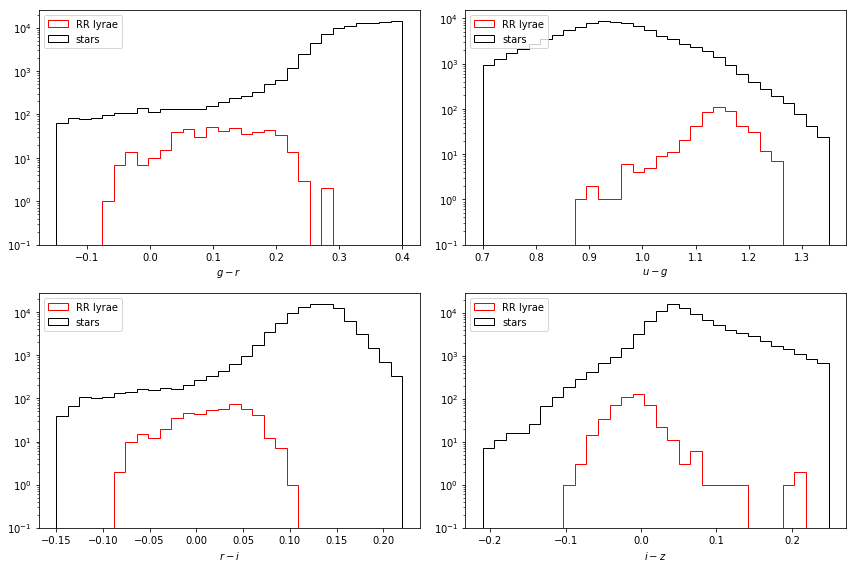

In [3]:
plt.figure(figsize=(12, 8))

for i in range(4):
    color = X[:, i]
    bins = np.linspace(np.nanmin(color), np.nanmax(color), 31)
    
    plt.subplot(221 + i)
    plt.hist(color[isRR], bins=bins, log=True, color="r", histtype="step", label="RR lyrae")
    plt.hist(color[~isRR], bins=bins, log=True, color="k", histtype="step", label="stars")
    plt.xlabel(color_names[i])
    plt.legend(loc="upper left")
    
plt.tight_layout()
plt.show()

## A closer 2D look...
Maybe using color-color diagrams we can easily classify RR Lyrae.

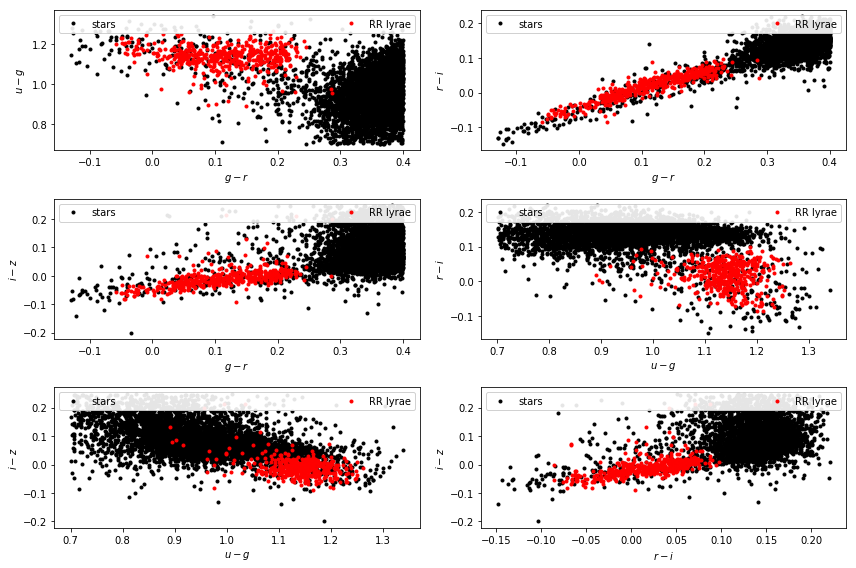

In [4]:
plt.figure(figsize=(12, 8))

k = 1
for i in range(4):
    c1 = X[:, i]
    for j in range(i + 1, 4):
        c2 = X[:, j]
        plt.subplot(320 + k)
        plt.plot(c1[noRR], c2[noRR], "k.", label="stars")
        plt.plot(c1[isRR], c2[isRR], "r.", label="RR lyrae")
        plt.xlabel(color_names[i])
        plt.ylabel(color_names[j])
        plt.legend(loc="upper right", framealpha=0.9, mode="expand", ncol=2)
        k += 1
        
plt.tight_layout()
plt.show()

## As close as we can *see* (3D)
What if we plot three colors? Of course we cannot continue with four colors because of our 3D perception limit.

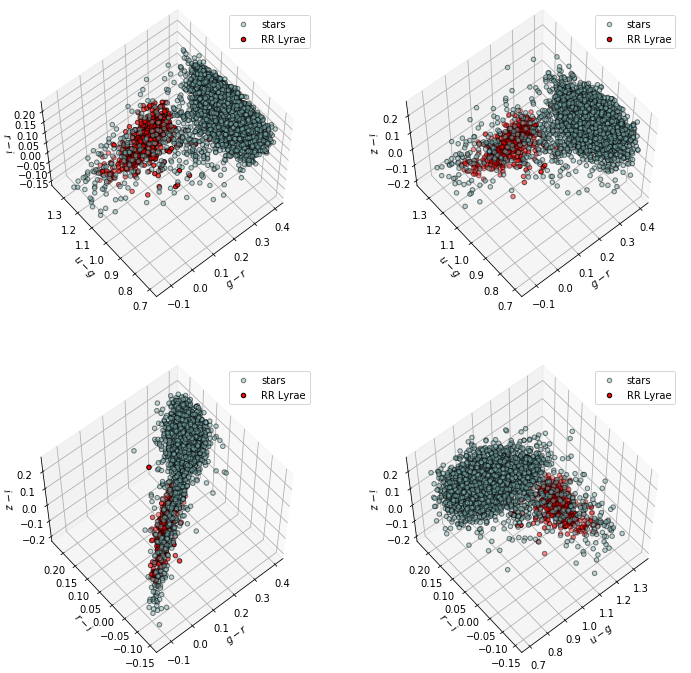

In [5]:
from mpl_toolkits.mplot3d import Axes3D

combinations = [(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)]

fig = plt.figure(figsize=(12, 12))
for index, combination in enumerate(combinations):
    i, j, k = combination
    ax = fig.add_subplot(221 + index, projection='3d')
    ax.view_init(60, -130)  # set camera position for better visualization
    ax.scatter(X[:, i][noRR], X[:, j][noRR], X[:, k][noRR], c=[0.5,0.7,0.7], marker="o", alpha=0.5, edgecolors="k", label="stars")
    ax.scatter(X[:, i][isRR], X[:, j][isRR], X[:, k][isRR], c="r", edgecolors="k", label="RR Lyrae")
    ax.set_xlabel(color_names[i])
    ax.set_ylabel(color_names[j])
    ax.set_zlabel(color_names[k])
    ax.legend()

plt.show()

## Creating a classifier
The 3D plots do not significantly improve the *manual classification*, compared to the 2D plots. In both cases, we see a *tail* where RR Lyrae variables reside. Instead, we would like to have:
* mathematical formulation
* automation
* estimates on completeness and contamination of the classification method

# $k$-nearest neighbors classification

Looking at the scatter plots, we find two blobs corresponding to the different classes. Our mind uses the proximity of the points to form a "mental boundary region". Automation of the procedure, as well as the extension to arbitrary number of dimensions is possible by mimicking the human behaviour:

> We classify a new point to the class that dominates its surroundings!

But what is the "neighborhood" of a point? One could search along a radius... but that has the problem that if it is small, we **will not find neighbors** for points "leaving the herd", and if it is large, then **we lose resolution** in dense parts, effectively throughing away information! We would like to have a *varibale bandwidth* selection method.

> So, we find the $k$ nearest neighbors!

Let's see a 2D example. We got two parameters and training data that are classified as being *red* or *blue*. The question is how do we classify a new point? The following images are taken from [3] (the first one was edited by us.)

## Animated example
<img src="knn_neigh_initial.jpg",width=600/>
<center>Figure 1.1: training data and a point to classify. </center>

<img src="knn_neigh.gif", width=600>
<center>Figure 1.2: classification using majority votes of $k$ neighbors.</center>

<img src="knn_neigh_mult.gif", width=600>
<center>Figure 1.3: classification of points along a broken line.</center>

## Applying $k$-NN on the photometric data

In [6]:
# split the sample in a training and test subset
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25], random_state=0)

N_tot = len(y)          # number of stars
N_st = np.sum(y == 0)   # number of non-RR Lyrae stars
N_rr = N_tot - N_st     # number of RR Lyrae
N_train = len(y_train)  # size of training sample
N_test = len(y_test)    # size of test sample
N_plot = 5000 + N_rr    # number of stars plotted (for better visualization)
Ncolors = np.arange(1, X.shape[1] + 1)    # number of available colors

In [7]:
# PERFORM CLASSIFICATION FOR VARIOUS VALUES OF k

# for each 'k', store the classifier and predictions on test sample
classifiers = []
predictions = []
kvals = [1, 3, 10]                           # k values to be used

for k in kvals:
    classifiers.append([])
    predictions.append([])
    for nc in Ncolors:
        clf = KNeighborsClassifier(n_neighbors=k)    # prepare the classifiers
        clf.fit(X_train[:, :nc], y_train)            # supply training data
        y_pred = clf.predict(X_test[:, :nc])         # predict class of test data

        classifiers[-1].append(clf)
        predictions[-1].append(y_pred)

# use astroML
completeness, contamination = completeness_contamination(predictions, y_test)

print "completeness", completeness
print "contamination", contamination


SyntaxError: Missing parentheses in call to 'print' (<ipython-input-7-7876d6375664>, line 22)

In [ ]:
# COMPUTE DECISION BOUNDARY

clf = classifiers[1][1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71), np.linspace(ylim[0], ylim[1], 81))
Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
Z = Z.reshape(xx.shape)


# PLOT THE RESULTS

fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0, left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:], s=4, lw=0, cmap=plt.cm.binary, zorder=2)
im.set_clim(-0.5, 1)
im = ax.imshow(Z, origin='lower', aspect='auto', cmap=plt.cm.binary, zorder=1, extent=xlim + ylim)
im.set_clim(0, 2)
ax.contour(xx, yy, Z, [0.5], colors='k')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')
ax.text(0.02, 0.02, "k = %i" % kvals[1], transform=ax.transAxes)

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness[0], 'o-k', ms=6, label='k=%i' % kvals[0])
ax.plot(Ncolors, completeness[1], '^--k', ms=6, label='k=%i' % kvals[1])
ax.plot(Ncolors, completeness[2], 'v:k', ms=6, label='k=%i' % kvals[2])
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination[0], 'o-k', label='k=%i' % kvals[0])
ax.plot(Ncolors, contamination[1], '^--k', label='k=%i' % kvals[1])
ax.plot(Ncolors, contamination[2], 'v:k', label='k=%i' % kvals[2])
ax.legend(loc='lower right', bbox_to_anchor=(1.0, 0.79))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

## Choosing $k$

### $k$ must be small...
> $\large+$ only nearby points are taken into account

> $\large-$ it too small, noisy decision boundaries (see change of classification in Figure 1.2 for small $k$'s)

### $k$ must be large...
> $\large+$ assuming infinite sample, for $k \rightarrow \infty$, the *error rate* is minimized

> $\large-$ **but** real-life samples are finite, so large $k$ results to loss of resolution (over-smoothing)

### Some approaches

> take $k = \sqrt{N}$

> use *cross-validation* to select optimal $k$

> if $2$ classes, go for an odd $k$ to avoid ties

In [4] we find an example of over-smoothing...

<img src="k1.jpg" width=400>
<img src="k5.jpg" width=400>
<img src="k399.jpg" width=400>

## Weighted $k$NN
Each vote can be weighted by the distance (or *similarity*). For more, look at [5].

## In search of a metric...
* What does "near" mean? This implies that we need a **metric** which rarely exists in our features. Maybe one of our parameter's span is $\left[1, 100\right]$ and another's $\left[0, 1\right]$. Should we apply **feature weighting**?
* Is the commonly-used Euclidean metric the appropriate choice for our data?
* What if all or some of our data are categorial? What is the metric in this case (see Hamming distance)?

For more information, consult [6].

## Pros
* no need to assume distribution
* simple & intuitive
* robust for large samples

## Cons
* hard to select $k$
* computationally expensive, $O(nkd)$ - optimization is possible but not for all cases
* for small samples, we have to rely on parametric distributions

# Support Vector Machine classification

Support vector machine (SVM) is a way of choosing a linear decision boundary between different classes. The boundary is decided by maximizing the distance between the distance of the closest point from either class. This distance is called the *margin*. Points on the margins are called *support vectors*.

## Linear boundaries

<img src="support_vector.jpg">
<center>
Figure 2.1: Two different classes of stars (blue and red stars) are bounded by the red line. The points filled with yellow color are the *support vectors*.
</center>

In order to understand the method we give a simple example. In Figure 2.1, we illustrate the radius versus temperature scatter plot of two different types of stars, the blue and red stars. A lot of possible lines (blue lines in Figure 2.1) can bound the two classes. However, the red line bounds the classes in the most optimum way. This means that the distance between the red line and the closest points (the closest points are penetrated by the dashed lines) from either class is maximum. The red line is the margin and the closest points are the support vectors. If an unclassified star is located on the left side of the boundary, it is classified as blue star and if it is located on the right side, it is a red star. This method can be applied for multiple classes too (Figure 2.2).

<img src="svm_many_classes.png">
<center>
Figure 2.2: Support vector machine applied to three different classes.
</center>

## N-D

If our sample of stars is characterized by three parameters (X label, Y label, Z label), radius, temperature and mass, then the scatter plot has 3 dimensions (Figure 2.3). The boundary between the classes in the 3-D plot is a plane. Because of the fact that the method can be extrapolated at N-dimensions, the boundary is a *hyperplane*.

<img src="svm_3d.png">
<center>
Figure 2.3: Support vector machine applied for 3-D features and three classes.
</center>

## Applying linear SVM on the photometric data

In the next block, we define a function that applies SVM on our data. If the boolean argument is set to `True`, it applies the linear SVM, otherwise it uses Gaussian radial basis function kernel (RBF.)

In [8]:
def apply_SVM(linear):
    if linear:
        kernel_to_use = "linear"
        gamma_to_use = "auto"
    else:
        kernel_to_use = "rbf"
        gamma_to_use = 20.0

    def compute_SVM(Ncolors):
        classifiers = []
        predictions = []

        for nc in Ncolors:
            print "    Computing for", nc, "color(s)..."
            # perform support vector classification
            clf = SVC(kernel=kernel_to_use, gamma=gamma_to_use, class_weight='balanced')
            clf.fit(X_train[:, :nc], y_train)
            y_pred = clf.predict(X_test[:, :nc])

            classifiers.append(clf)
            predictions.append(y_pred)

        return classifiers, predictions

    print("Performing SVM classification...")

    classifiers, predictions = compute_SVM(Ncolors)

    completeness, contamination = completeness_contamination(predictions, y_test)

    print "completeness", completeness
    print "contamination", contamination

    # COMPUTE THE DECISION BOUNDARY

    clf = classifiers[1]

    if linear:
        w = clf.coef_[0]
        a = -w[0] / w[1]
        yy = np.linspace(-0.1, 0.4)
        xx = a * yy - clf.intercept_[0] / w[1]
    else:
        xlim = (0.7, 1.35)
        ylim = (-0.15, 0.4)
        xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 101), np.linspace(ylim[0], ylim[1], 101))
        Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
        Z = Z.reshape(xx.shape)
        # smooth the boundary
        from scipy.ndimage import gaussian_filter
        Z = gaussian_filter(Z, 2)

    # PLOT THE RESULTS

    fig = plt.figure(figsize=(12, 6))
    fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0, left=0.1, right=0.95, wspace=0.2)

    # left plot: data and decision boundary
    ax = fig.add_subplot(121)
    im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:], s=4, lw=0, cmap=plt.cm.binary, zorder=2)
    if linear:
        ax.plot(xx, yy, '-k')
    else:
        ax.contour(xx, yy, Z, [0.5], colors='k')

    im.set_clim(-0.5, 1)
    ax.set_xlim(0.7, 1.35)
    ax.set_ylim(-0.15, 0.4)
    ax.set_xlabel('$u-g$')
    ax.set_ylabel('$g-r$')

    # plot completeness vs Ncolors
    ax = fig.add_subplot(222)
    ax.plot(Ncolors, completeness, 'o-k', ms=6)
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.set_ylabel('completeness')
    ax.set_xlim(0.5, 4.5)
    ax.set_ylim(-0.1, 1.1)
    ax.grid(True)

    # plot contamination vs Ncolors
    ax = fig.add_subplot(224)
    ax.plot(Ncolors, contamination, 'o-k', ms=6)
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
    ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
    ax.set_xlabel('N colors')
    ax.set_ylabel('contamination')
    ax.set_xlim(0.5, 4.5)
    ax.set_ylim(-0.1, 1.1)
    ax.grid(True)

    plt.show()
    
apply_SVM(linear=True)

SyntaxError: invalid syntax (<ipython-input-8-bbcfb1268b34>, line 14)

## Non-linear boundaries

Sometimes, linear boundaries may not be optimal and a non-linear SVM should be used. In order to find non-linear boundaries the concept of *kernelization* can be used. In the left panel of Figure 2.4, we have a scatter plot of two different classes (e.g. red and green stars with different radii and temperatures). We cannot use a linear boundary for these classes. In order to solve this problem, we use a kernel function which adds an extra dimension to our data. As we can see, in the right panel of Figure 2.4 the classes can be bounded by a plane in 3-D space. Projecting the plane boundary at 2-D, we find the non-linear boundary of our classes.

<img src="kernel.png">
<center>
Figure 2.4: When no linear boundaries can be used the SVM method can be applied by using kernel.
</center>

## Applying kernelized SVM on the photometric data

In [9]:
apply_SVM(linear=False)

NameError: name 'apply_SVM' is not defined

## Misclassifications

In Figure 2.2 we notice that the blue points class is contaminated by some green 
points (*misclassified* points). Likewise, the green points class is contaminated by blue points. This contamination makes it difficult to define the boundary between the two classes. In this situation SVM finds the hyperplane that maximizes the margin and minimizes the misclassifications.


## Pros and Cons

Pros:
- Good at dealing with high dimensional data
- Works well on small data sets

Cons:
- Picking the right kernel and parameters can be computationally intensive
- It suffers from contamination


For further information on SVM, see [7] and [8].

### References
[1] http://esoads.eso.org/abs/2003LNP...635...85B

[2] https://www.eso.org/sci/publications/messenger/archive/no.13-jun78/messenger-no13-15-17.pdf

[3] https://importq.wordpress.com/2017/11/24/mnist-analysis-using-knn/

[4] https://idc9.github.io/stor390/notes/cross_validation/cross_validation.html

[5] https://epub.ub.uni-muenchen.de/1769/1/paper_399.pdf

[6] http://www.cs.haifa.ac.il/~rita/ml_course/lectures/KNN.pdf

[7] https://www.youtube.com/watch?v=N1vOgolbjSc

[8] http://www.saedsayad.com/support_vector_machine.htm